<h1><b>인공지능개론 6주차 과제<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 회귀(abalone.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import</b></h2>

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

<h2><b>1. 데이터 로딩</b></h2>

In [14]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/abalone.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)

# 데이터 확인
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [15]:
# 컬렴명 확인
print(df.columns)

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [16]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수의 분포를 확인</li>

,count
Rings,
9,689
10,634
8,568
11,487
7,391
12,267
6,259
13,203
14,126


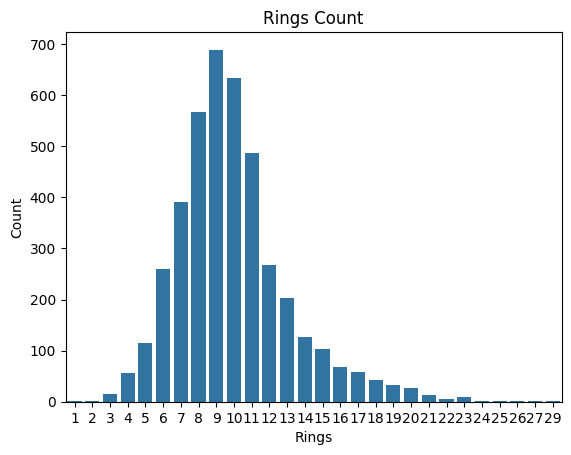

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="Rings")
plt.xlabel("Rings")
plt.ylabel("Count")
plt.title("Rings Count")
# 레이블 갯수 확인 (숫자)
df['Rings'].value_counts()

<h2><b>4. 데이터 전처리</b></h2>

In [18]:
df = df.drop(columns=["id"])  # drop id column

label_encoder = LabelEncoder()
df["Sex"] = label_encoder.fit_transform(df["Sex"])  # encode 'Sex'

X = df.drop("Rings", axis=1).values
y = df["Rings"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


<h2><b>5. 모델 정의</b></h2>

In [19]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionModel(input_dim=X.shape[1])

<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [21]:
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

<h2><b>8. 학습곡선 시각화 </b></h2>

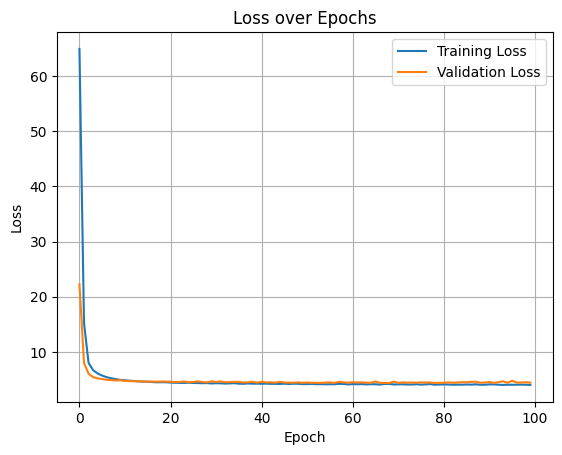

In [22]:
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


<h2><b>9. 모델 평가 </b></h2>

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_val_pred_reg = model(X_val_tensor).detach().numpy().flatten()
y_val_true_reg = y_val_tensor.numpy().flatten()

mae = mean_absolute_error(y_val_true_reg, y_val_pred_reg)
rmse = np.sqrt(mean_squared_error(y_val_true_reg, y_val_pred_reg))
r2 = r2_score(y_val_true_reg, y_val_pred_reg)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 1.5372942686080933
RMSE: 2.130371821191573
R²: 0.5807485580444336
